# Постановка задачи

- Классификация транзакций на предмет мошенничества
- Метрика F1

## Описание датасета

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 120)
#pd.set_option('display.width', 500)

from sklearn.preprocessing import LabelEncoder

In [2]:
desc = pd.read_csv('Variable_Definitions.csv')
desc

,Column Name,Definition
0,TransactionId,Уникальный идентификатор транзакции на платформе
1,BatchId,Уникальное идентификатор присваевыемый пакету транзакций для обработки
2,AccountId,Уникальный идентификатор пользователя на платформе
3,SubscriptionId,Уникальный идентификатор идентифицирующий подписку клиента
4,CustomerId,Уникальный идентификатор привязанный к аккаунту
5,CurrencyCode,Валюта страны
6,CountryCode,Цифровой географический код страны
7,ProviderId,Поставщик товара
8,ProductId,Идентификатор купленного товара
9,ProductCategory,Категория товара


In [3]:
train = pd.read_csv('train.csv', index_col='TransactionId', encoding='UTF-8')
train['train/test'] = 'train'
train

,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,ClientProfile,TrasactionCategory,train/test
TransactionId,,,,,,,,,,,,,,,,,,
76871,36123,3957,887,4406,EUR,49,6,10,airtime,3,1000.0,1000,2018-11-15 02:18:49,2,0,4,3,train
73770,15642,4841,3829,4406,EUR,49,4,6,financial_services,2,-20.0,20,2018-11-15 02:19:08,2,0,0,2,train
26203,53941,4229,222,4683,EUR,49,6,1,airtime,3,500.0,500,2018-11-15 02:44:21,2,0,3,2,train
380,102363,648,2185,988,EUR,49,1,21,utility_bill,3,20000.0,21800,2018-11-15 03:32:55,2,0,3,1,train
28195,38780,4841,3829,988,EUR,49,4,6,financial_services,2,-644.0,644,2018-11-15 03:34:21,2,0,0,3,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18019,129395,4841,3829,3795,EUR,49,4,6,financial_services,2,-5000.0,5000,2019-01-31 23:08:18,2,0,0,1,train
102758,87434,2577,3326,2994,EUR,49,5,1,airtime,3,1000.0,1000,2019-01-31 23:44:44,4,0,3,1,train
10757,114753,4841,3829,2994,EUR,49,4,6,financial_services,2,-50.0,50,2019-01-31 23:45:42,2,0,0,2,train


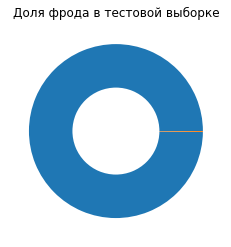

0    0.998248
1    0.001752
Name: FraudResult, dtype: float64

In [4]:
plt.pie(train['FraudResult'].value_counts(100), wedgeprops=dict(width=0.5))
plt.title('Доля фрода в тестовой выборке')
plt.show()

train['FraudResult'].value_counts(100)

- Очевидно, что датасет несбалансированный и при обучении модели нужно применять undersampling или oversampling. Но это позже.
- Доля фрода 1.7%

In [5]:
test = pd.read_csv('test.csv', index_col='TransactionId', encoding='UTF-8')
test['train/test'] = 'test'
test

,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,ClientProfile,TrasactionCategory,train/test
TransactionId,,,,,,,,,,,,,,,,,
32298,96810,3933,3115,4380,EUR,49,1,8,tv,3,11000.0,11330,2019-02-01 01:27:35,2,0,1,test
39603,114595,4841,3829,4380,EUR,49,4,6,financial_services,2,-5000.0,5000,2019-02-01 01:28:33,2,0,3,test
32642,104610,3933,3115,4380,EUR,49,6,10,airtime,3,2000.0,2000,2019-02-01 01:32:03,2,0,2,test
23161,78588,835,3465,1180,EUR,49,5,15,financial_services,3,10000.0,10000,2019-02-01 02:31:36,2,2,2,test
109097,59419,835,3465,1180,EUR,49,5,15,financial_services,3,10000.0,10000,2019-02-01 02:36:04,2,2,2,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89881,96668,4841,3829,3078,EUR,49,4,6,financial_services,2,-1000.0,1000,2019-02-13 09:54:09,2,0,3,test
91597,3503,3439,2643,3874,EUR,49,6,10,airtime,3,1000.0,1000,2019-02-13 09:54:25,2,3,2,test
82501,118602,4841,3829,3874,EUR,49,4,6,financial_services,2,-20.0,20,2019-02-13 09:54:35,2,0,1,test


# EDA

In [6]:
# для убобства (чтобы не дублировать код) объединил 2 train & test в один с соответсвующими метками
df = pd.concat([train, test], axis=0)

del train, test

In [7]:
df

,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,ClientProfile,TrasactionCategory,train/test
TransactionId,,,,,,,,,,,,,,,,,,
76871,36123,3957,887,4406,EUR,49,6,10,airtime,3,1000.0,1000,2018-11-15 02:18:49,2,0.0,4,3,train
73770,15642,4841,3829,4406,EUR,49,4,6,financial_services,2,-20.0,20,2018-11-15 02:19:08,2,0.0,0,2,train
26203,53941,4229,222,4683,EUR,49,6,1,airtime,3,500.0,500,2018-11-15 02:44:21,2,0.0,3,2,train
380,102363,648,2185,988,EUR,49,1,21,utility_bill,3,20000.0,21800,2018-11-15 03:32:55,2,0.0,3,1,train
28195,38780,4841,3829,988,EUR,49,4,6,financial_services,2,-644.0,644,2018-11-15 03:34:21,2,0.0,0,3,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89881,96668,4841,3829,3078,EUR,49,4,6,financial_services,2,-1000.0,1000,2019-02-13 09:54:09,2,NaN,0,3,test
91597,3503,3439,2643,3874,EUR,49,6,10,airtime,3,1000.0,1000,2019-02-13 09:54:25,2,NaN,3,2,test
82501,118602,4841,3829,3874,EUR,49,4,6,financial_services,2,-20.0,20,2019-02-13 09:54:35,2,NaN,0,1,test


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95662 entries, 76871 to 35670
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   BatchId               95662 non-null  int64  
 1   AccountId             95662 non-null  int64  
 2   SubscriptionId        95662 non-null  int64  
 3   CustomerId            95662 non-null  int64  
 4   CurrencyCode          95662 non-null  object 
 5   CountryCode           95662 non-null  int64  
 6   ProviderId            95662 non-null  int64  
 7   ProductId             95662 non-null  int64  
 8   ProductCategory       95662 non-null  object 
 9   ChannelId             95662 non-null  int64  
 10  Amount                95662 non-null  float64
 11  Value                 95662 non-null  int64  
 12  TransactionStartTime  95662 non-null  object 
 13  PricingStrategy       95662 non-null  int64  
 14  FraudResult           79890 non-null  float64
 15  ClientProfile  

In [9]:
df[df.columns].nunique().sort_values(ascending=False)

BatchId                 94809
TransactionStartTime    94556
CustomerId               3742
AccountId                3633
SubscriptionId           3627
Amount                   1676
Value                    1517
ProductId                  23
ProductCategory             9
ProviderId                  6
ClientProfile               5
ChannelId                   4
PricingStrategy             4
TrasactionCategory          3
FraudResult                 2
train/test                  2
CountryCode                 1
CurrencyCode                1
dtype: int64

- В данных отсутсвуют пропуски
- Практически все фичи категориальные
- 3 объектных фичи



## BatchId, CountryCode, CurrencyCode
 - BatchId - Уникальное идентификатор присваевыемый пакету транзакций для обработки
 - CountryCode - Цифровой географический код страны
 - CurrencyCode - Валюта страны

In [10]:
# выбросим BatchId, CountryCode, CurrencyCode т.к. они не несут полезной информации
df.drop(['BatchId', 'CountryCode', 'CurrencyCode'], axis=1, inplace=True)

## AccountId, SubscriptionId, CustomerId
- AccountId - Уникальный идентификатор пользователя на платформе
- SubscriptionId - Уникальный идентификатор идентифицирующий подписку клиента
- CustomerId - Уникальный идентификатор привязанный к аккаунту

In [11]:
# Далее при анализе фичей я буду использовать график, отражающий как распределение значений,
# так и отношение с целевой пременной
def plot_distribution(df, var, target, **kwargs):
    df = df[df['train/test'] == 'train']
    row = kwargs.get('row', None)
    col = kwargs.get('col', None)
    facet = sns.FacetGrid(df, hue=target, aspect=4, row=row, col=col)
    facet.map(sns.kdeplot, var, shade=True)
    facet.set(xlim=(0, df[var].max()))
    facet.add_legend()
    plt.show()

In [12]:
df[['AccountId', 'SubscriptionId', 'CustomerId']].drop_duplicates()

,AccountId,SubscriptionId,CustomerId
TransactionId,,,
76871,3957,887,4406
73770,4841,3829,4406
26203,4229,222,4683
380,648,2185,988
28195,4841,3829,988
...,...,...,...
123513,557,4806,893
88037,4841,3829,893
9743,4840,3829,893


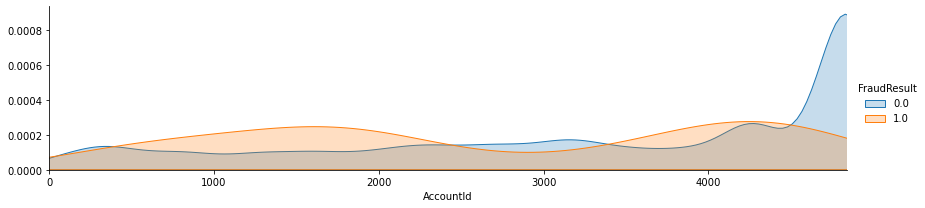

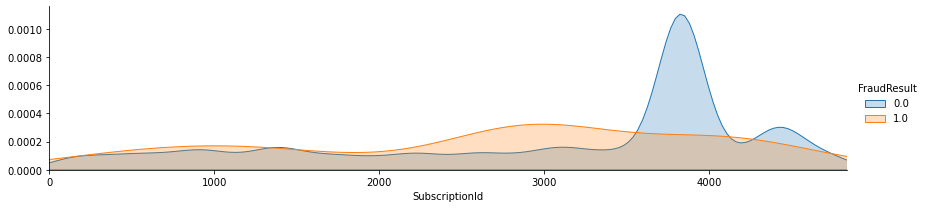

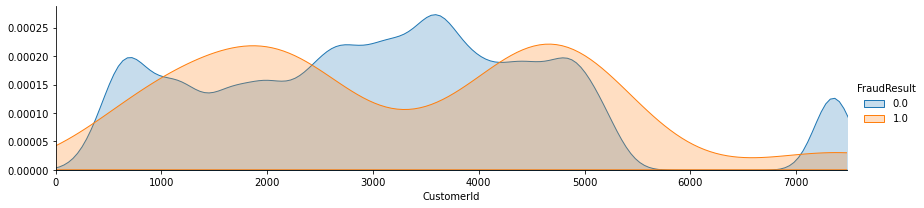

In [13]:
for feature in ['AccountId', 'SubscriptionId', 'CustomerId']:
    plot_distribution(df, feature, 'FraudResult')

- транзакции пользователей с аккаунтом в районе 3000 и более 4500 тысяч больше склонны к фроду
- транзакции пользователей с идентификатором подписки около 3800 сильно склонны к фроду
- транзакции пользователей с номерами 800, 3000-3500 и более 7000 больше склонны к фроду
Без дополнительной информации по каждой фиче сложно объяснить их значимость. Пока оставим в неизменном виде.

## TransactionStartTime - Время начала транзакции

In [14]:
# выделим год, месяц, день, час а так же день недели из даты
time_cols = ['year', 'month', 'day', 'hour', 'dayofweek']
df['TransactionStartTime'] = df['TransactionStartTime'].astype('datetime64[ns]')
df['year'] = df['TransactionStartTime'].dt.year.astype(int)
df['month'] = df['TransactionStartTime'].dt.month.astype(int)
df['day'] = df['TransactionStartTime'].dt.day.astype(int)
df['hour'] = df['TransactionStartTime'].dt.hour.astype(int)
df['dayofweek'] = df['TransactionStartTime'].dt.dayofweek.astype(int)

#df.drop(['TransactionStartTime'], axis=1, inplace=True)

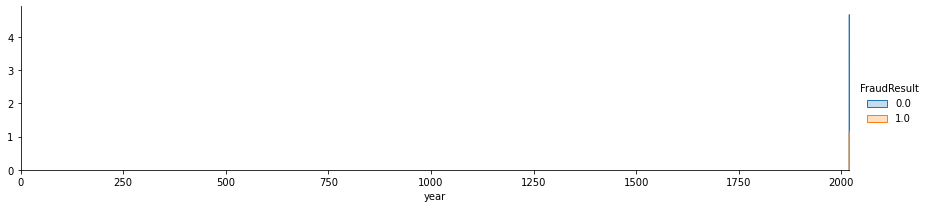

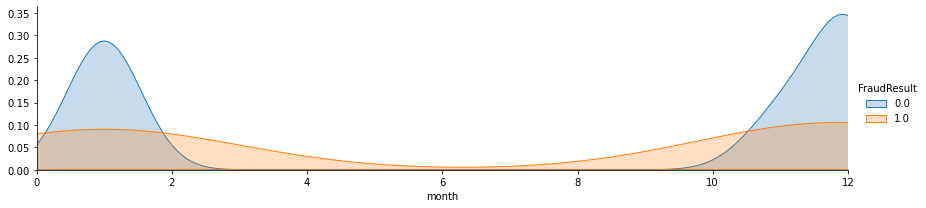

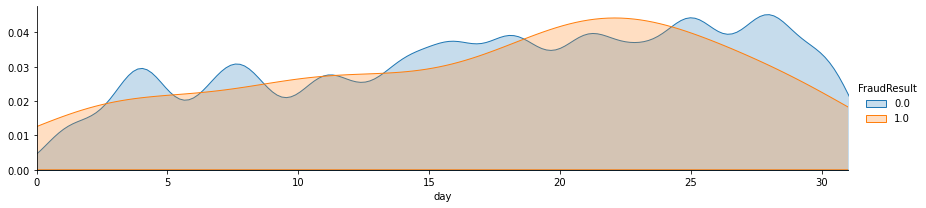

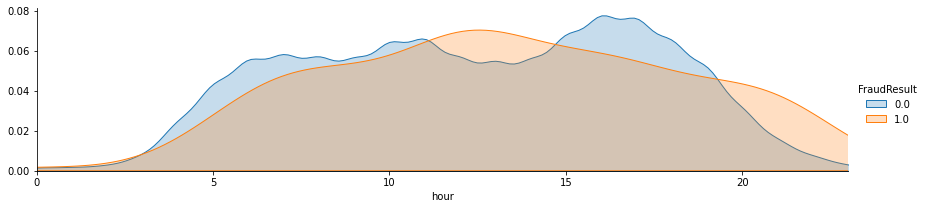

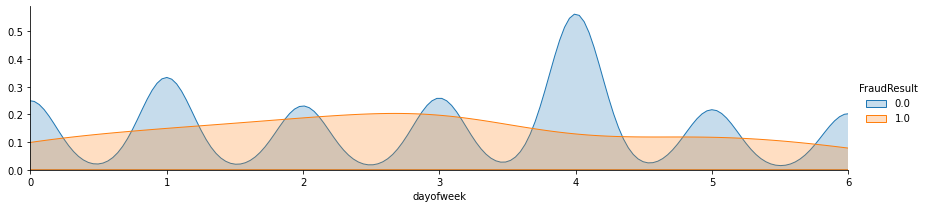

In [15]:
for feature in time_cols:
    plot_distribution(df, feature, 'FraudResult')

- вероятность совершения мошенических операций увеличивается к концу года и приходтся на промежуток с ноября по январь
- вероятность совершения мошенических операций увеличивается к концу месяца с пиком на 20е числа
- в течение дня наибольшая вероятность появления фрода возникает в районе 13 часов, при этом в 13 и после 20 часов вероятность фрода выше, чем вероятность обычной операции
- по дням недели вероятноть возникновения фрода распределена равномерно

## PricingStrategy, TrasactionCategory

- PricingStrategy - Категория ценовой структуры
- TrasactionCategory - Рисковость транзакции по мнению внешней системы

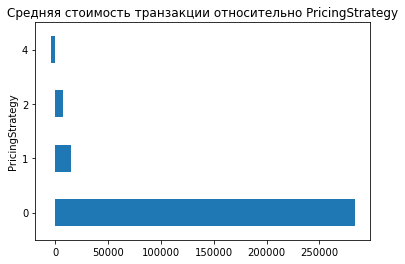

In [16]:
# Исходя из описания фичи PricingStrategy и TrasactionCategory могут быть порядковыми. Проверим PricingStrategy
df.groupby('PricingStrategy')['Amount'].mean().plot(kind='barh')
plt.title('Средняя стоимость транзакции относительно PricingStrategy')
plt.show()

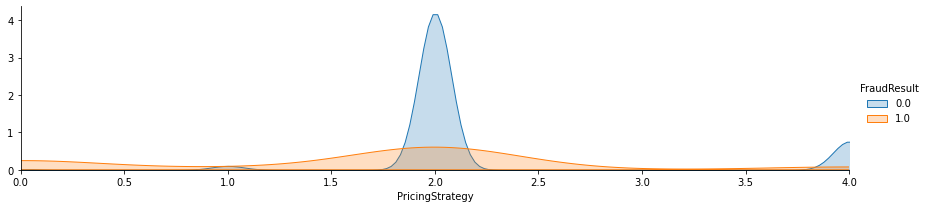

In [17]:
plot_distribution(df, 'PricingStrategy', 'FraudResult')

Среди всех операций можно выделить транзакции с ценовой стратегией 0 категории, т.к. среди них количество мошеннических операций крайне велико относительно всех операций. Горб в раоне 2 обусловлен наибольшим числом операций этой категории

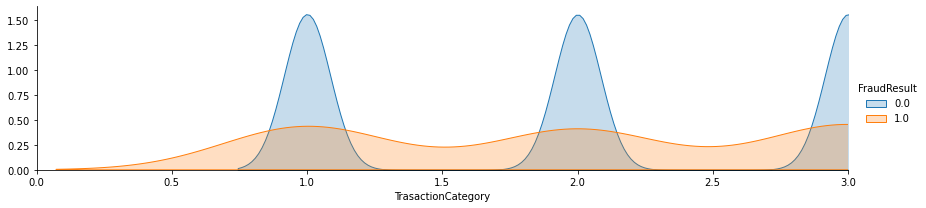

In [18]:
plot_distribution(df, 'TrasactionCategory', 'FraudResult')

Фрод может присутсвовать во всех категориях транзакции с одинаковой долей вероятности

## ProductId, ProductCategory, ProviderId, ClientProfile, ChannelId

- ProductId - Идентификатор купленного товара
- ProductCategory - Категория товара
- ProviderId - Поставщик товара
- ClientProfile - Тип профиля клиента по мнения платформы
- ChannelId - Тип канала по которому прошел платеж web/android/ios/pay later/checkout

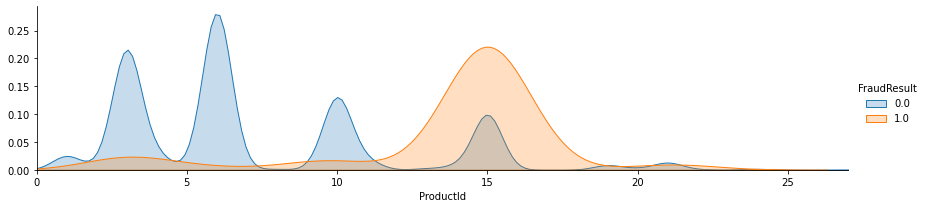

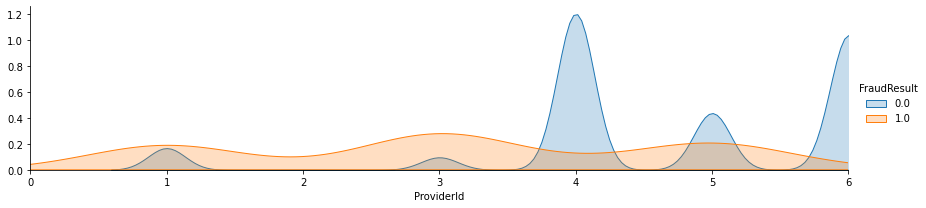

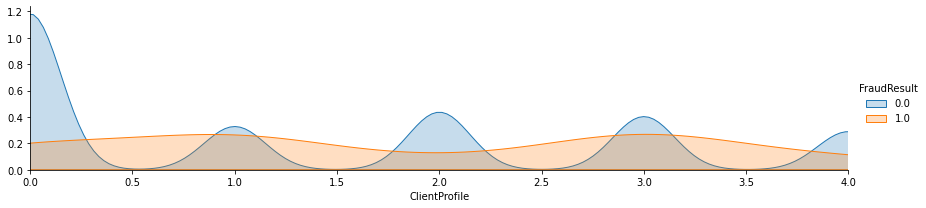

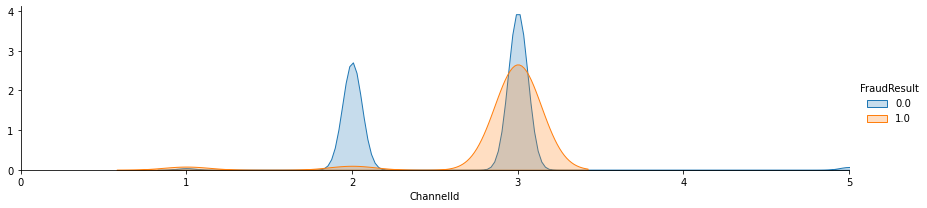

In [19]:
cols = ['ProductId', 'ProviderId', 'ClientProfile', 'ChannelId']
for feature in cols:
    plot_distribution(df, feature, 'FraudResult')

Наиболее важны первые 2 графика, которые явно указывают на id продукта и провайдера, среди которых доля фрода преобладает над обычными операциями
Транзакции с id продукта 15 в большей степени являются мошенническими, 

In [20]:
# закодируем ProductCategory в числовую перемнную
labelencoder = LabelEncoder()

df['ProductCategory_cat'] = labelencoder.fit_transform(df['ProductCategory'])
df.drop('ProductCategory', axis=1, inplace=True)

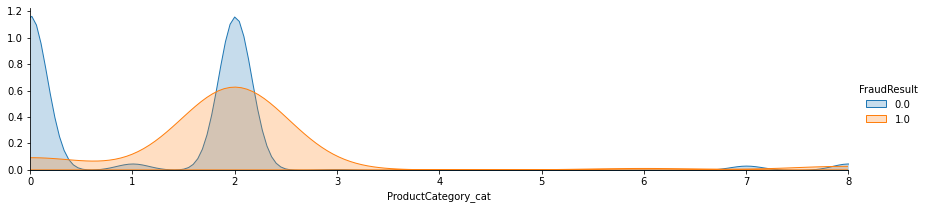

In [21]:
plot_distribution(df, 'ProductCategory_cat', 'FraudResult')

In [22]:
# Закодируем все непорядковые категориальные переменные через get_dummies
cols = ['ProductId', 'ProductCategory_cat', 'ProviderId', 'ClientProfile', 'ChannelId']
df = pd.get_dummies(data=df, columns=cols)

## Amount, Value
- Amount - Стоимость сделки. Положительный говорит о списании/отрицательный о зачислении
- Value - Абсолютное значение суммы

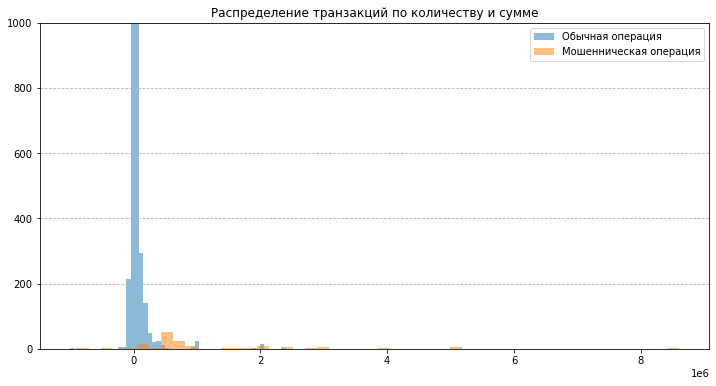

In [23]:
plt.figure(figsize=(12,6))

plt.hist(df[df['FraudResult'] == 0]['Amount'], bins=50, alpha=0.5, label='Обычная операция')
plt.hist(df[df['FraudResult'] == 1]['Amount'], bins=50, alpha=0.5, label='Мошенническая операция')

plt.grid(axis='y', ls='--')
plt.title('Распределение транзакций по количеству и сумме')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_ylim(0, 1000)
plt.show()

Заметно, что большая часть мошшенических транзакций соредоточена в районе до 1000 EU, при этом практически все транзакции в размере от 500 до 1000 EU являются мошенническими

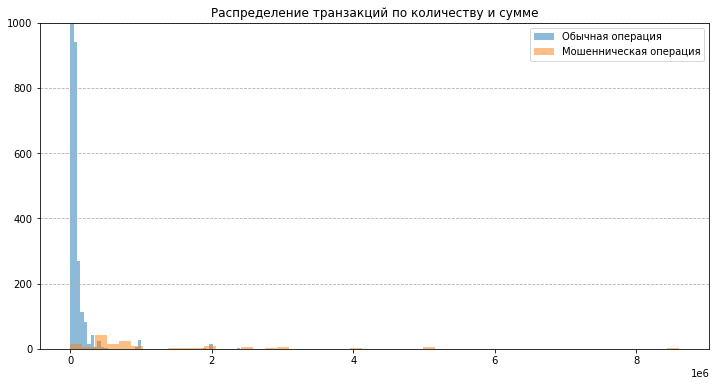

In [24]:
plt.figure(figsize=(12,6))

plt.hist(df[df['FraudResult'] == 0]['Value'], bins=50, alpha=0.5, label='Обычная операция')
plt.hist(df[df['FraudResult'] == 1]['Value'], bins=50, alpha=0.5, label='Мошенническая операция')

plt.grid(axis='y', ls='--')
plt.title('Распределение транзакций по количеству и сумме')
plt.legend(loc='upper right')
ax = plt.gca()
ax.set_ylim(0, 1000)
plt.show()

Аналогичная ситуация и с размером. Логично, что эти фичи сильно корреклированы друг с другом и с таргетом

## Корреляция

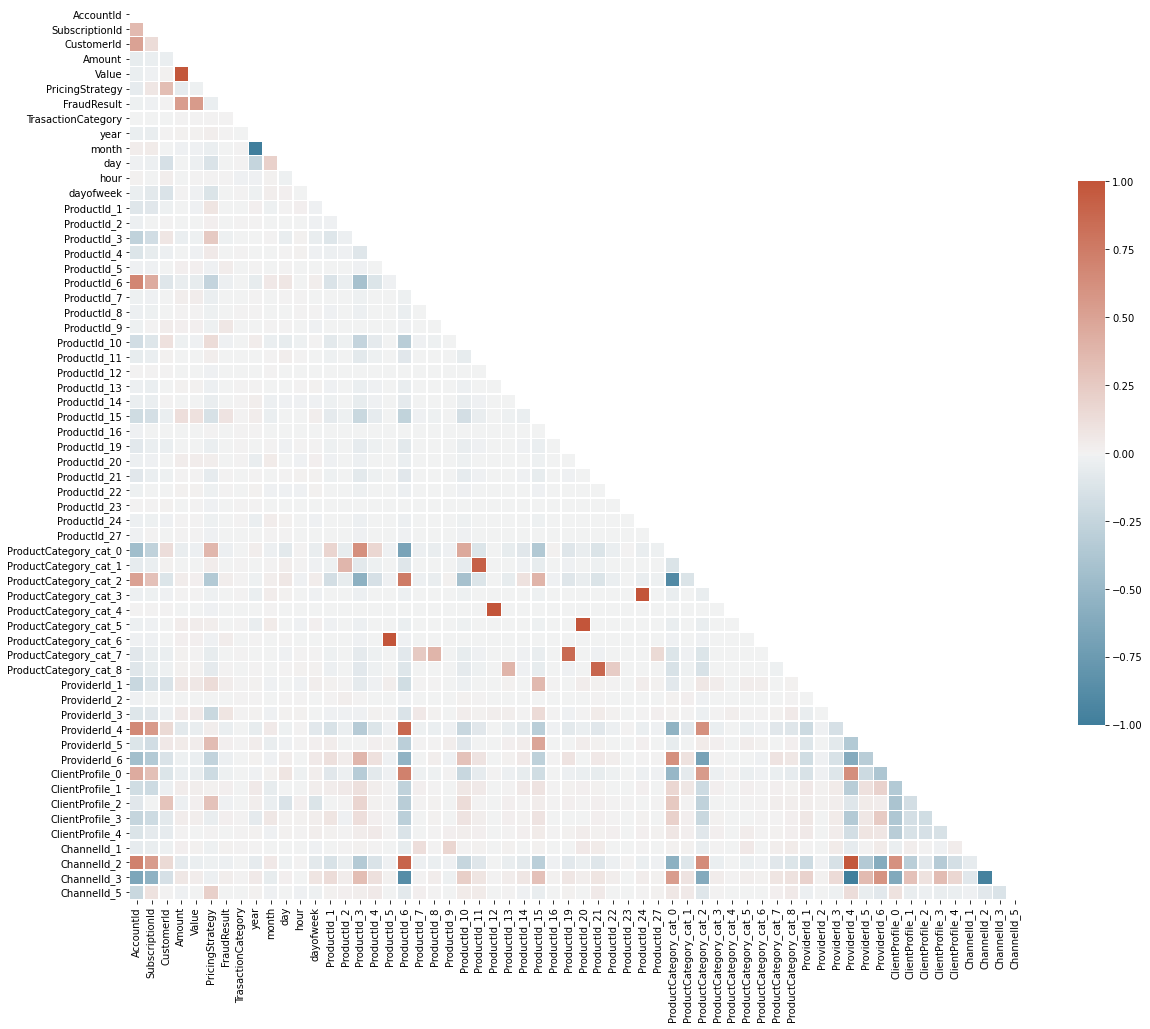

In [25]:
# correlation matrix
corr_matrix = df.drop('train/test', axis=1).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
cmap2 = sns.diverging_palette(150, 275, s=80, l=55, n=9)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix,
            mask=mask, # какие числа отображать
            cmap=cmap, # цветовая гамма
            vmax=1, # максимум корреляции
            vmin=-1, # минимум корреляции
            center=0, # центр корреляции
            square=True, # квадратная ли матрица
            linewidths=.5, # ширина линий между квадратами
            cbar_kws={"shrink": .5}, # уменьшить диаграму сбоку (cbar)
            annot=False # добавить подписи
           )
plt.show()

In [26]:
df

,AccountId,SubscriptionId,CustomerId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult,TrasactionCategory,train/test,year,month,day,hour,dayofweek,ProductId_1,ProductId_2,ProductId_3,ProductId_4,ProductId_5,ProductId_6,ProductId_7,ProductId_8,ProductId_9,ProductId_10,ProductId_11,ProductId_12,ProductId_13,ProductId_14,ProductId_15,ProductId_16,ProductId_19,ProductId_20,ProductId_21,ProductId_22,ProductId_23,ProductId_24,ProductId_27,ProductCategory_cat_0,ProductCategory_cat_1,ProductCategory_cat_2,ProductCategory_cat_3,ProductCategory_cat_4,ProductCategory_cat_5,ProductCategory_cat_6,ProductCategory_cat_7,ProductCategory_cat_8,ProviderId_1,ProviderId_2,ProviderId_3,ProviderId_4,ProviderId_5,ProviderId_6,ClientProfile_0,ClientProfile_1,ClientProfile_2,ClientProfile_3,ClientProfile_4,ChannelId_1,ChannelId_2,ChannelId_3,ChannelId_5
TransactionId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
76871,3957,887,4406,1000.0,1000,2018-11-15 02:18:49,2,0.0,3,train,2018,11,15,2,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0
73770,4841,3829,4406,-20.0,20,2018-11-15 02:19:08,2,0.0,2,train,2018,11,15,2,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
26203,4229,222,4683,500.0,500,2018-11-15 02:44:21,2,0.0,2,train,2018,11,15,2,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
380,648,2185,988,20000.0,21800,2018-11-15 03:32:55,2,0.0,1,train,2018,11,15,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
28195,4841,3829,988,-644.0,644,2018-11-15 03:34:21,2,0.0,3,train,2018,11,15,3,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89881,4841,3829,3078,-1000.0,1000,2019-02-13 09:54:09,2,NaN,3,test,2019,2,13,9,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
91597,3439,2643,3874,1000.0,1000,2019-02-13 09:54:25,2,NaN,2,test,2019,2,13,9,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
82501,4841,3829,3874,-20.0,20,2019-02-13 09:54:35,2,NaN,1,test,2019,2,13,9,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0


In [27]:
df_train = df[['AccountId', 'SubscriptionId', 'CustomerId', 'Amount', 'Value', 'PricingStrategy',
       'TrasactionCategory', 'train/test', 'year', 'month', 'day', 'hour',
       'dayofweek', 'ProductId_1', 'ProductId_2', 'ProductId_3', 'ProductId_4',
       'ProductId_5', 'ProductId_6', 'ProductId_7', 'ProductId_8',
       'ProductId_9', 'ProductId_10', 'ProductId_11', 'ProductId_12',
       'ProductId_13', 'ProductId_14', 'ProductId_15', 'ProductId_16',
       'ProductId_19', 'ProductId_20', 'ProductId_21', 'ProductId_22',
       'ProductId_23', 'ProductId_24', 'ProductId_27', 'ProductCategory_cat_0',
       'ProductCategory_cat_1', 'ProductCategory_cat_2',
       'ProductCategory_cat_3', 'ProductCategory_cat_4',
       'ProductCategory_cat_5', 'ProductCategory_cat_6',
       'ProductCategory_cat_7', 'ProductCategory_cat_8', 'ProviderId_1',
       'ProviderId_2', 'ProviderId_3', 'ProviderId_4', 'ProviderId_5',
       'ProviderId_6', 'ClientProfile_0', 'ClientProfile_1', 'ClientProfile_2',
       'ClientProfile_3', 'ClientProfile_4', 'ChannelId_1', 'ChannelId_2',
       'ChannelId_3', 'ChannelId_5', 'FraudResult']]
df_train = df_train[df_train['train/test'] == 'train']
df_train.drop('train/test', axis=1, inplace=True)

## Итоги EDA

Необходимая предобработка данных была проведена в прочих пунктах данной работы:
- закодированы категориальные признаки;
- убраны признаки, ялвяющиеся константами;
- выбраны признаки с высокой корреляцией, в дальнейшем, возможно, их стоит исключить из модели;
- далее на этапе подбора гиперпараметров модели будет оценено качество моделей при дополнении исходной выборки синтетическими данными.

# Подбор и настройка модели

Стоит задача бинарной классификации: определить, уволится ли сотрудник или нет.
В качестве моделей выберем:
 - RandomForestClassifier
 - XGBoostClassifier
    
Данные модели не требуют нормализацию признаков, в том числе исходный набор данных обладает небольшим количеством объектов и признаков, также видна нелинейная зависимость между целевой переменной и отдельными признаками, что было наглядно представлено в 2. Это еще больше подтверждает выбор решающих деревьев в качестве основной модели. 

In [28]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, roc_auc_score

In [29]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop('FraudResult', axis = 1),
                                                    np.array(df_train['FraudResult']), 
                                                    test_size=0.2,  
                                                    random_state=40)
print(f'Доля положителных меток для трейна: {format(sum(y_train)/X_train.shape[0])}')
print(f'Доля положителных меток для теста: {format(sum(y_test)/X_test.shape[0])}')

Доля положителных меток для трейна: 0.0017837025910627112
Доля положителных меток для теста: 0.0016272374514958068


Проведем первоначальное приближение моделей с рандомизированным побором гиперпараметров на кросс-валидации по 3 фолдам с помощью RandomizedSearchCV. 

Ограничимся основными гиперпараметрами для RandomForestClassifier:
 - n_estimators - число деревьев
 - min_samples_split - минимальное число объектов, при котором выполняется расщепление
 - min_samples_leaf - ограничение на число объектов в листьях
 - max_depth - максимальная глубина дерева
 - criterion - критерий расщипления

In [30]:
param_grid_for_forest = { 'n_estimators': np.arange(10, 300, 2),
                          'max_depth': np.arange(1, 20, 1),
                          'min_samples_split': np.arange(2,150,1),
                          'min_samples_leaf': np.arange(2,60,1),
                          'max_features' : np.arange(1,X_train.shape[1],1)}

In [31]:
grid_search = RandomizedSearchCV(RandomForestClassifier(),scoring='f1', 
                                 param_distributions=param_grid_for_forest, 
                                 cv = 3,verbose = 1,random_state = 40)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.3min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58]),
                                        'min_samples...
       140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164,
       166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190,
       192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216,
       218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242,
       244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268,
       270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290

In [32]:
# результаты в виде таблицы отранжированной по рангу 1-3 места
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.863891,0.042004,0.036722,0.001107,20,84,55,33,9,"{'n_estimators': 20, 'min_samples_split': 84, 'min_samples_leaf': 55, 'max_features': 33, 'max_depth': 9}",0.756098,0.780488,0.704545,0.747044,0.031657,1
1,6.016404,0.193667,0.259229,0.001849,250,129,4,18,4,"{'n_estimators': 250, 'min_samples_split': 129, 'min_samples_leaf': 4, 'max_features': 18, 'max_depth': 4}",0.756098,0.780488,0.704545,0.747044,0.031657,1
6,8.350033,0.614577,0.183037,0.007973,176,44,31,37,9,"{'n_estimators': 176, 'min_samples_split': 44, 'min_samples_leaf': 31, 'max_features': 37, 'max_depth': 9}",0.756098,0.780488,0.704545,0.747044,0.031657,1


In [33]:
print(f'Лучший показатель F1: {grid_search.best_score_}')
print(f'Лучшие параметры: {grid_search.best_params_}')

Лучший показатель F1: 0.7470436067997044
Лучшие параметры: {'n_estimators': 20, 'min_samples_split': 84, 'min_samples_leaf': 55, 'max_features': 33, 'max_depth': 9}


Аналогично и для XGBoostClassifier, для гиперпараметров: 
- n_estimators; 
- max_depth;
- subsample;
- colsample_bytree;
- reg_alpha;
- gamma

In [34]:
param_grid_for_xgb = {'n_estimators': np.arange(10, 300, 2),
                      'max_depth': np.arange(1,20,1),
                      'subsample' : [i/10.0 for i in range(1,10)],
                      'colsample_bytree':[i/10.0 for i in range(1,10)],
                      'reg_alpha':[0,1e-5, 1e-2, 0.1, 1, 100]    ,
                      'gamma' : [i/10.0 for i in range(1,10)]}

In [35]:
grid_search = RandomizedSearchCV(XGBClassifier(random_state=1), scoring='f1',
                                 param_distributions=param_grid_for_xgb, 
                                 cv = 3,verbose = 1,random_state = 40)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.7min finished


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
       166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190,
       192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216,
       218, 220, 222, 224, 226, 228, 

In [36]:
# результаты в виде таблицы отранжированной по рангу 1-3 места
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_reg_alpha,param_n_estimators,param_max_depth,param_gamma,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
6,8.282829,0.414238,0.079375,0.000919,0.9,0,254,13,0.6,0.4,"{'subsample': 0.9, 'reg_alpha': 0, 'n_estimators': 254, 'max_depth': 13, 'gamma': 0.6, 'colsample_bytree': 0.4}",0.823529,0.906667,0.883117,0.871104,0.034987,1
2,8.522809,0.453369,0.073009,0.003262,0.6,1,164,14,0.9,0.9,"{'subsample': 0.6, 'reg_alpha': 1, 'n_estimators': 164, 'max_depth': 14, 'gamma': 0.9, 'colsample_bytree': 0.9}",0.823529,0.888889,0.894737,0.869052,0.032278,2
0,2.945037,0.140869,0.063483,0.000733,0.9,1,80,10,0.6,0.5,"{'subsample': 0.9, 'reg_alpha': 1, 'n_estimators': 80, 'max_depth': 10, 'gamma': 0.6, 'colsample_bytree': 0.5}",0.811594,0.888889,0.906667,0.869050,0.041271,3


In [37]:
print(f'Лучший средний показатель F1: {grid_search.best_score_}')
print(f'Лучшие параметры: {grid_search.best_params_}')

Лучший средний показатель F1: 0.8711043205160852
Лучшие параметры: {'subsample': 0.9, 'reg_alpha': 0, 'n_estimators': 254, 'max_depth': 13, 'gamma': 0.6, 'colsample_bytree': 0.4}


Можно заметить, что XGBClassifier обладает заметно лучшим качеством. Далее использовать буду только ее.

Попробуем сгенерировать дополнительные синтетические объекты для минорного класса и оценим качество получившихся моделей, взяв параметры моделей из RandomizedSearchCV. Стоит обратить внимание, что при оценке качества модели с учетом новых синтетических объектов данные на тесте должны остаться в прежнем виде.

# Feature importance и побдор признаков

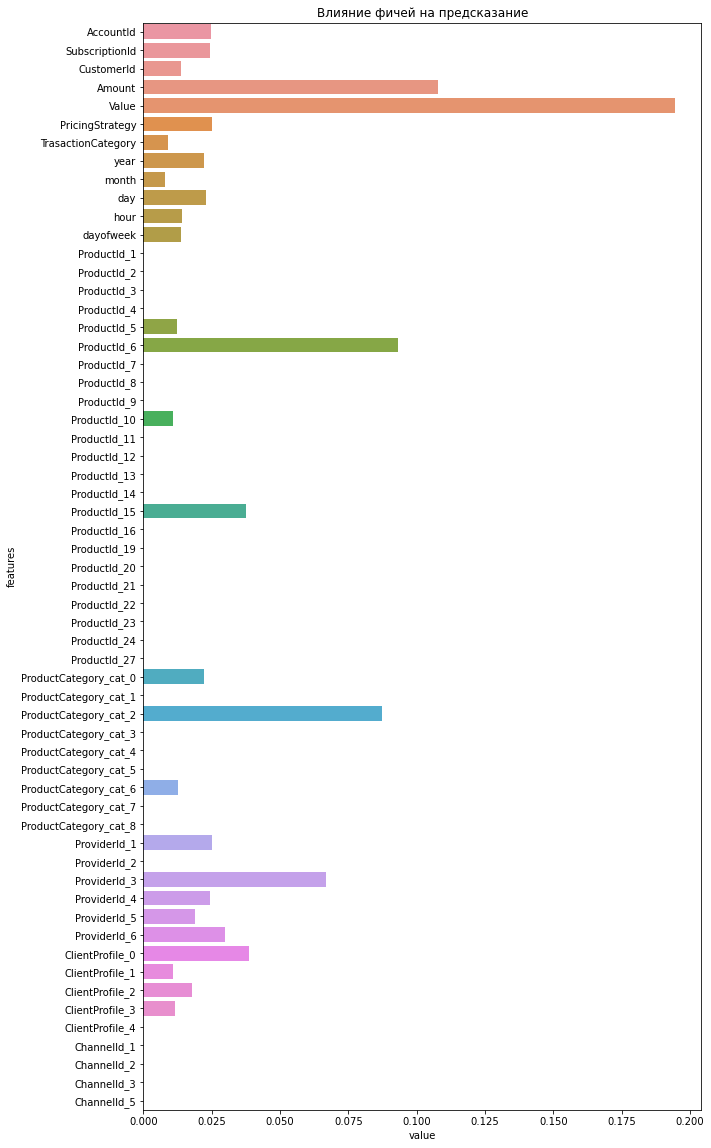

In [38]:
feat_importance = pd.DataFrame(X_train.columns, columns = ['features'])
feat_importance['value'] = grid_search.best_estimator_.feature_importances_

plt.figure(figsize=(10,20))
sns.barplot(y=feat_importance['features'], x=feat_importance['value'], orient='h')
plt.title('Влияние фичей на предсказание')
plt.show()

In [39]:
(feat_importance.sort_values('value', ascending=False) == 0).sum()

features     0
value       31
dtype: int64

In [40]:
# Вариант 1
drops_1 = feat_importance.sort_values('value')['features'][:35]
# Вариант 2
drops_2 = feat_importance.sort_values('value')['features'][:40]
# Вариант 3
drops_3 = feat_importance.sort_values('value')['features'][:45]

In [41]:
model_xgb = XGBClassifier(subsample=0.9,
                          reg_alpha=0,
                          n_estimators=254,
                          max_depth=13,
                          gamma=0.6,
                          colsample_bytree=0.4,
                          random_state=1)

model_xgb.fit(X_train,y_train)
predictions = model_xgb.predict_proba(X_train)[:,1]
print('Метрики для исходного датасета')
print(classification_report(y_test, model_xgb.predict(X_test)))
print(f'F1 score = {f1_score(y_test, model_xgb.predict(X_test))}')

Метрики для исходного датасета
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     15952
         1.0       0.92      0.85      0.88        26

    accuracy                           1.00     15978
   macro avg       0.96      0.92      0.94     15978
weighted avg       1.00      1.00      1.00     15978

F1 score = 0.8799999999999999


In [42]:
model_xgb.fit(X_train.drop(drops_1, axis=1),y_train)
predictions = model_xgb.predict_proba(X_train.drop(drops_1, axis=1))[:,1]
print('Метрики для варианта 1')
print(classification_report(y_test, model_xgb.predict(X_test.drop(drops_1, axis=1))))
print(f'F1 score = {f1_score(y_test, model_xgb.predict(X_test.drop(drops_1, axis=1)))}')

Метрики для варианта 1
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     15952
         1.0       0.96      0.85      0.90        26

    accuracy                           1.00     15978
   macro avg       0.98      0.92      0.95     15978
weighted avg       1.00      1.00      1.00     15978

F1 score = 0.8979591836734695


In [43]:
model_xgb.fit(X_train.drop(drops_2, axis=1),y_train)
predictions = model_xgb.predict_proba(X_train.drop(drops_2, axis=1))[:,1]
print('Метрики для варианта 2')
print(classification_report(y_test, model_xgb.predict(X_test.drop(drops_2, axis=1))))
print(f'F1 score = {f1_score(y_test, model_xgb.predict(X_test.drop(drops_2, axis=1)))}')

Метрики для варианта 2
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     15952
         1.0       0.92      0.88      0.90        26

    accuracy                           1.00     15978
   macro avg       0.96      0.94      0.95     15978
weighted avg       1.00      1.00      1.00     15978

F1 score = 0.9019607843137256


In [44]:
model_xgb.fit(X_train.drop(drops_3, axis=1),y_train)
predictions = model_xgb.predict_proba(X_train.drop(drops_3, axis=1))[:,1]
print('Метрики для варианта 3')
print(classification_report(y_test, model_xgb.predict(X_test.drop(drops_3, axis=1))))
print(f'F1 score = {f1_score(y_test, model_xgb.predict(X_test.drop(drops_3, axis=1)))}')

Метрики для варианта 3
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     15952
         1.0       0.92      0.88      0.90        26

    accuracy                           1.00     15978
   macro avg       0.96      0.94      0.95     15978
weighted avg       1.00      1.00      1.00     15978

F1 score = 0.9019607843137256


Снижение количества фичей для обучения так же немного улучшило скор модели. Между вариантами 2 и 3 разницы нет, поэтому я буду использвать вариант 3 для дальнейшей работы

# Тест модели с генерацией синтетических объектов

In [45]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

model_XGB = XGBClassifier(subsample=0.9,
                          reg_alpha=0,
                          n_estimators=254,
                          max_depth=13,
                          gamma=0.6,
                          colsample_bytree=0.4,
                          random_state=1)
smote = SMOTE(sampling_strategy='minority', random_state=40)

steps = [('smote',smote), ('model_XGB',model_XGB)]
pipeline = Pipeline(steps=steps)

In [46]:
smote_XGB = pipeline.fit(X_train.drop(drops_3, axis=1),y=y_train)

In [47]:
print(classification_report(y_test, smote_XGB.predict(X_test.drop(drops_3, axis=1))))
print(f'F1 score = {f1_score(y_test, smote_XGB.predict(X_test.drop(drops_3, axis=1)))}')

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     15952
         1.0       0.89      0.92      0.91        26

    accuracy                           1.00     15978
   macro avg       0.94      0.96      0.95     15978
weighted avg       1.00      1.00      1.00     15978

F1 score = 0.9056603773584906


Добавление синтетических данных чуть улучшило нашу модель. Для финального предсказания будем использовать XGBoost на  датасете со сгенерированными фичами.

# Предсказание

In [48]:
validation = df[['AccountId', 'SubscriptionId', 'CustomerId', 'Amount', 'Value', 'PricingStrategy',
       'TrasactionCategory', 'train/test', 'year', 'month', 'day', 'hour',
       'dayofweek', 'ProductId_1', 'ProductId_2', 'ProductId_3', 'ProductId_4',
       'ProductId_5', 'ProductId_6', 'ProductId_7', 'ProductId_8',
       'ProductId_9', 'ProductId_10', 'ProductId_11', 'ProductId_12',
       'ProductId_13', 'ProductId_14', 'ProductId_15', 'ProductId_16',
       'ProductId_19', 'ProductId_20', 'ProductId_21', 'ProductId_22',
       'ProductId_23', 'ProductId_24', 'ProductId_27', 'ProductCategory_cat_0',
       'ProductCategory_cat_1', 'ProductCategory_cat_2',
       'ProductCategory_cat_3', 'ProductCategory_cat_4',
       'ProductCategory_cat_5', 'ProductCategory_cat_6',
       'ProductCategory_cat_7', 'ProductCategory_cat_8', 'ProviderId_1',
       'ProviderId_2', 'ProviderId_3', 'ProviderId_4', 'ProviderId_5',
       'ProviderId_6', 'ClientProfile_0', 'ClientProfile_1', 'ClientProfile_2',
       'ClientProfile_3', 'ClientProfile_4', 'ChannelId_1', 'ChannelId_2',
       'ChannelId_3', 'ChannelId_5', 'FraudResult']]
validation = validation[validation['train/test'] == 'test']
validation.drop(['train/test', 'FraudResult'], axis=1, inplace=True)

In [49]:
validation

,AccountId,SubscriptionId,CustomerId,Amount,Value,PricingStrategy,TrasactionCategory,year,month,day,hour,dayofweek,ProductId_1,ProductId_2,ProductId_3,ProductId_4,ProductId_5,ProductId_6,ProductId_7,ProductId_8,ProductId_9,ProductId_10,ProductId_11,ProductId_12,ProductId_13,ProductId_14,ProductId_15,ProductId_16,ProductId_19,ProductId_20,ProductId_21,ProductId_22,ProductId_23,ProductId_24,ProductId_27,ProductCategory_cat_0,ProductCategory_cat_1,ProductCategory_cat_2,ProductCategory_cat_3,ProductCategory_cat_4,ProductCategory_cat_5,ProductCategory_cat_6,ProductCategory_cat_7,ProductCategory_cat_8,ProviderId_1,ProviderId_2,ProviderId_3,ProviderId_4,ProviderId_5,ProviderId_6,ClientProfile_0,ClientProfile_1,ClientProfile_2,ClientProfile_3,ClientProfile_4,ChannelId_1,ChannelId_2,ChannelId_3,ChannelId_5
TransactionId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
32298,3933,3115,4380,11000.0,11330,2,1,2019,2,1,1,4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
39603,4841,3829,4380,-5000.0,5000,2,3,2019,2,1,1,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
32642,3933,3115,4380,2000.0,2000,2,2,2019,2,1,1,4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0
23161,835,3465,1180,10000.0,10000,2,2,2019,2,1,2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
109097,835,3465,1180,10000.0,10000,2,2,2019,2,1,2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89881,4841,3829,3078,-1000.0,1000,2,3,2019,2,13,9,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
91597,3439,2643,3874,1000.0,1000,2,2,2019,2,13,9,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
82501,4841,3829,3874,-20.0,20,2,1,2019,2,13,9,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0


In [50]:
validation['Fraud_predict'] = smote_XGB.predict(validation.drop(drops_3, axis=1))

In [51]:
validation.drop(['AccountId', 'SubscriptionId', 'CustomerId', 'Amount', 'Value',
       'PricingStrategy', 'TrasactionCategory', 'year', 'month', 'day', 'hour',
       'dayofweek', 'ProductId_1', 'ProductId_2', 'ProductId_3', 'ProductId_4',
       'ProductId_5', 'ProductId_6', 'ProductId_7', 'ProductId_8',
       'ProductId_9', 'ProductId_10', 'ProductId_11', 'ProductId_12',
       'ProductId_13', 'ProductId_14', 'ProductId_15', 'ProductId_16',
       'ProductId_19', 'ProductId_20', 'ProductId_21', 'ProductId_22',
       'ProductId_23', 'ProductId_24', 'ProductId_27', 'ProductCategory_cat_0',
       'ProductCategory_cat_1', 'ProductCategory_cat_2',
       'ProductCategory_cat_3', 'ProductCategory_cat_4',
       'ProductCategory_cat_5', 'ProductCategory_cat_6',
       'ProductCategory_cat_7', 'ProductCategory_cat_8', 'ProviderId_1',
       'ProviderId_2', 'ProviderId_3', 'ProviderId_4', 'ProviderId_5',
       'ProviderId_6', 'ClientProfile_0', 'ClientProfile_1', 'ClientProfile_2',
       'ClientProfile_3', 'ClientProfile_4', 'ChannelId_1', 'ChannelId_2',
       'ChannelId_3', 'ChannelId_5'], axis=1, inplace=True)

In [52]:
validation.to_csv('validation.csv')

# Выводы

На проект было потрачено около 18 часов. По итогу была построена модель, предсказывающая мошеннические транзакции. При анализе было выявлено, что наибольшое влияние на отток сотрудников из компании имеют признаки, связанные с размером транзакции и продуктом/категорий продукта.

Полученное качество модели, оцененное с поомщью метрики F1 score составляет 0.905, что говорит о высокой предсказательной способности модели. 


Возможные улучшения:
- точнее отобрать значимые для модели признаки (убрать скоррелированные)
- точнее подобрать гиперпараметры (использован Randomsearch, далее можно в интервале провести поиск по Gridsearch)
- Наряду с оверсемплингом использовать андерсемплинг, чтобы еще больше сбалансировать данные

 - Какие дополнительные данные могли бы помочь в данной задаче?
Для меня остались непонятны признаки, описывающие аккаунт клиента, его подписку. Еще было бы здорово поработать с большим объемом транзакций
 - Какой методы для решения задачи вы бы хотели использовать, но не успели?
Точнее подобрать гиперпараметры через Gridsearch  и применить андерсэмплинг. Еще можно графики по резултатам настроики модели построить.
 - Какая бизнес-метрика будет, на ваш взгляд, основной в данной задаче?
Как минимум снизить затраты на обработку аккаунта (хранение данных, регистрация, возможно реклама и т.д). Как максимум данная задача позволит выявить новые мошеннические схемы.